In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import keras
from keras_unet.models import custom_unet

2023-02-02 00:04:06.273702: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/Nathan Arnett Calcification'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')


In [4]:
images = np.load(images_file)
labels = np.load(labels_file)

In [5]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [6]:
p = np.random.permutation(len(images))

In [7]:
images = images[p]
labels = labels[p]

In [8]:
images = images.astype(np.float64)
labels = labels.astype(np.float64)

In [9]:
for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

In [10]:
images.shape

(503, 512, 512, 1)

In [11]:
labels.shape

(503, 512, 512, 1)

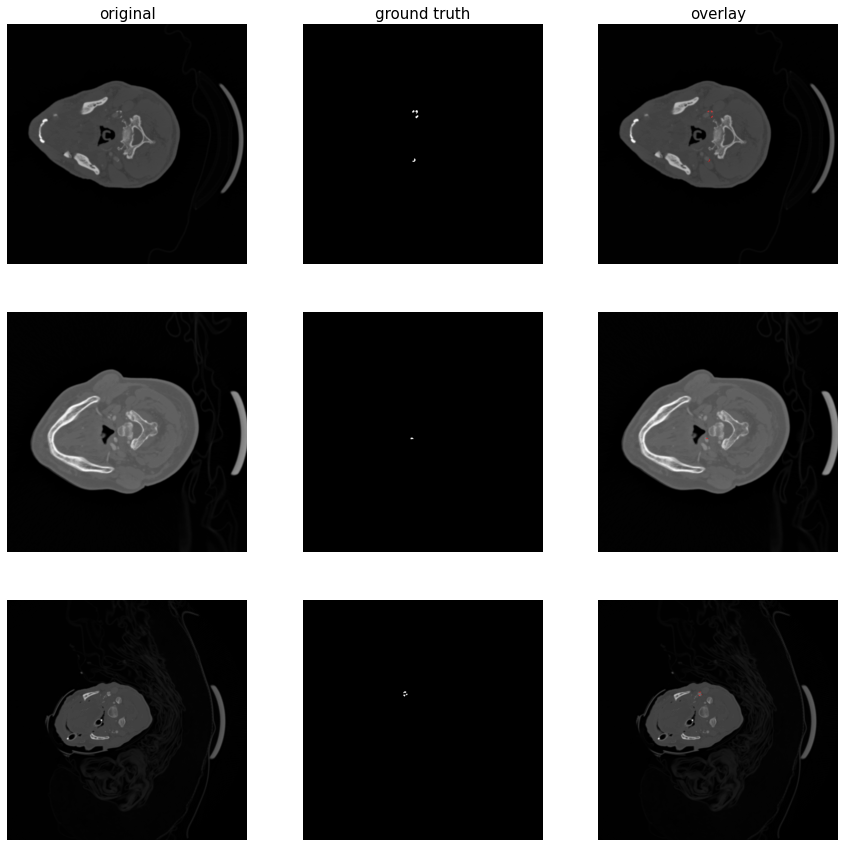

In [12]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=images, mask_imgs=labels, nm_img_to_plot=3, figsize=5)

In [13]:
X_train = images[0:300]
y_train = labels[0:300]
X_val = images[300:400]
y_val = labels[300:400]
X_test = images[400:]
y_test = labels[400:]

In [14]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

(2, 512, 512, 1) (2, 512, 512, 1)


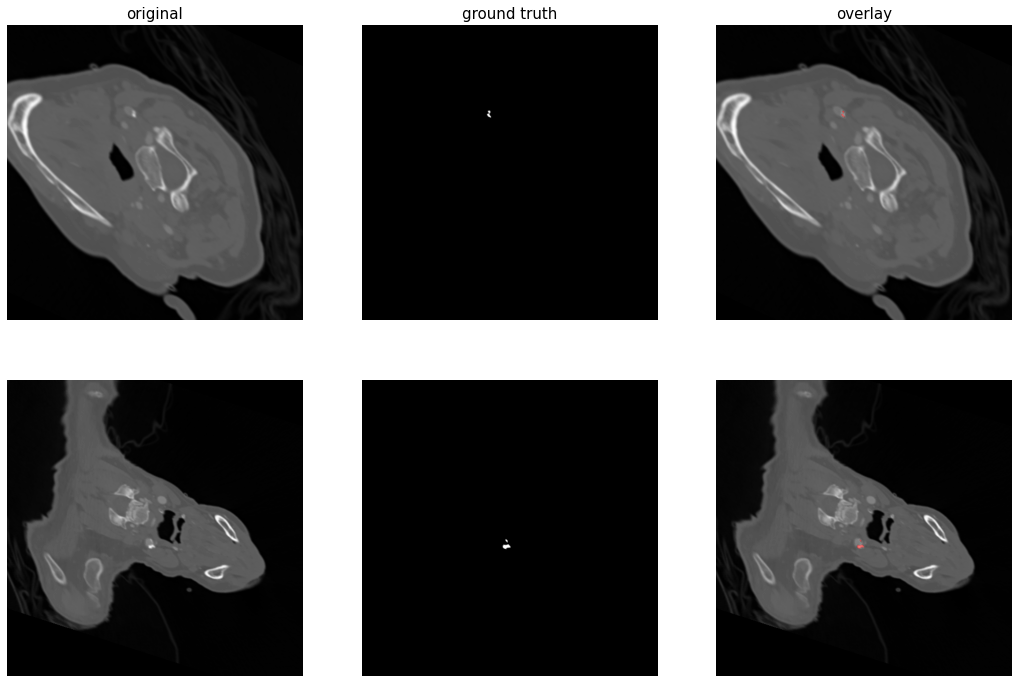

In [15]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [16]:
from keras_unet_collection import models, losses
import torch

model = models.swin_unet_2d((512, 512, 1), filter_num_begin=64,
                               n_labels=1, depth=4, stack_num_down=4, stack_num_up=4,
                               patch_size=(4, 4), num_heads=[4, 8, 16, 16],
                               window_size=[4, 4, 4, 4], num_mlp=512, 
                               output_activation='Sigmoid', shift_window=True, name='swin_unet')

#Softmax

2023-02-02 00:04:51.717341: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-02 00:04:51.823315: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:87:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-02 00:04:51.823349: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-02 00:04:51.823379: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-02 00:04:51.823394: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-02 00:04:51.824413: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [17]:
model.summary()

Model: "swin_unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
patch_extract (patch_extract)   (None, 16384, 16)    0           input_1[0][0]                    
__________________________________________________________________________________________________
patch_embedding (patch_embeddin (None, 16384, 64)    1049664     patch_extract[0][0]              
__________________________________________________________________________________________________
swin_transformer_block (SwinTra (None, 16384, 64)    83460       patch_embedding[0][0]            
____________________________________________________________________________________

In [18]:
from tensorflow.keras import optimizers
#from tensorflow.keras.optimizers import Adam
from keras_unet.metrics import iou, iou_thresholded, dice_coef
from keras_unet_collection import losses
#from keras_unet.losses import jaccard_distance

In [19]:
model.compile(loss='binary_crossentropy',
              #loss=jaccard_distance,
              optimizer=optimizers.Adam(lr=1e-3),
              #optimizer = 'Adam',
              metrics=[iou, iou_thresholded])

/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [22]:
history = model.fit(#X_train, 
                    #y_train,
                    train_gen,
                    steps_per_epoch=50,
                    epochs=200,
                    #batch_size=16, 
                    #epochs=200,
                    validation_data=(X_val, y_val))

Epoch 1/200
50/50 [==============================] - 12s 239ms/step - loss: 0.0019 - iou: 0.0076 - iou_thresholded: 0.0161 - val_loss: 0.0023 - val_iou: 0.0018 - val_iou_thresholded: 0.0019
Epoch 2/200
50/50 [==============================] - 12s 235ms/step - loss: 0.0020 - iou: 0.0073 - iou_thresholded: 0.0139 - val_loss: 0.0024 - val_iou: 0.0019 - val_iou_thresholded: 0.0019
Epoch 3/200
50/50 [==============================] - 12s 236ms/step - loss: 0.0020 - iou: 0.0072 - iou_thresholded: 0.0159 - val_loss: 0.0021 - val_iou: 0.0020 - val_iou_thresholded: 0.0019
Epoch 4/200
50/50 [==============================] - 12s 241ms/step - loss: 0.0018 - iou: 0.0061 - iou_thresholded: 0.0197 - val_loss: 0.0018 - val_iou: 0.0026 - val_iou_thresholded: 0.0019
Epoch 5/200
50/50 [==============================] - 12s 235ms/step - loss: 0.0024 - iou: 0.0074 - iou_thresholded: 0.0114 - val_loss: 0.0021 - val_iou: 0.0023 - val_iou_thresholded: 0.0019
Epoch 6/200
50/50 [==============================]

Epoch 44/200
50/50 [==============================] - 12s 237ms/step - loss: 0.0012 - iou: 0.0469 - iou_thresholded: 0.0483 - val_loss: 9.7649e-04 - val_iou: 0.1059 - val_iou_thresholded: 0.1684
Epoch 45/200
50/50 [==============================] - 12s 237ms/step - loss: 0.0010 - iou: 0.0891 - iou_thresholded: 0.1102 - val_loss: 9.7153e-04 - val_iou: 0.1175 - val_iou_thresholded: 0.1546
Epoch 50/200
50/50 [==============================] - 12s 235ms/step - loss: 0.0010 - iou: 0.0863 - iou_thresholded: 0.0895 - val_loss: 0.0013 - val_iou: 0.0938 - val_iou_thresholded: 0.2167
Epoch 51/200
50/50 [==============================] - 12s 235ms/step - loss: 0.0010 - iou: 0.0764 - iou_thresholded: 0.0819 - val_loss: 0.0011 - val_iou: 0.0790 - val_iou_thresholded: 0.0842
Epoch 52/200
50/50 [==============================] - 12s 238ms/step - loss: 9.6745e-04 - iou: 0.0696 - iou_thresholded: 0.0719 - val_loss: 9.2921e-04 - val_iou: 0.1294 - val_iou_thresholded: 0.1551
Epoch 53/200
50/50 [=========

Epoch 90/200
50/50 [==============================] - 12s 234ms/step - loss: 8.5871e-04 - iou: 0.1148 - iou_thresholded: 0.1416 - val_loss: 9.9966e-04 - val_iou: 0.1064 - val_iou_thresholded: 0.0710
Epoch 91/200
50/50 [==============================] - 12s 236ms/step - loss: 0.0013 - iou: 0.0595 - iou_thresholded: 0.0582 - val_loss: 0.0011 - val_iou: 0.0583 - val_iou_thresholded: 0.0045
Epoch 92/200
50/50 [==============================] - 12s 241ms/step - loss: 8.9180e-04 - iou: 0.0896 - iou_thresholded: 0.1153 - val_loss: 8.9799e-04 - val_iou: 0.1409 - val_iou_thresholded: 0.2140
Epoch 93/200
50/50 [==============================] - 12s 235ms/step - loss: 9.5001e-04 - iou: 0.1146 - iou_thresholded: 0.1382 - val_loss: 0.0012 - val_iou: 0.0668 - val_iou_thresholded: 0.0172
Epoch 94/200
50/50 [==============================] - 12s 234ms/step - loss: 0.0011 - iou: 0.0765 - iou_thresholded: 0.0822 - val_loss: 0.0010 - val_iou: 0.0996 - val_iou_thresholded: 0.1291
Epoch 95/200
50/50 [=====

Epoch 132/200
50/50 [==============================] - 12s 242ms/step - loss: 9.7277e-04 - iou: 0.0792 - iou_thresholded: 0.0855 - val_loss: 8.5961e-04 - val_iou: 0.1368 - val_iou_thresholded: 0.2181
Epoch 133/200
50/50 [==============================] - 12s 234ms/step - loss: 9.1304e-04 - iou: 0.0916 - iou_thresholded: 0.1187 - val_loss: 9.8626e-04 - val_iou: 0.1205 - val_iou_thresholded: 0.2648
Epoch 134/200
50/50 [==============================] - 12s 234ms/step - loss: 0.0011 - iou: 0.1001 - iou_thresholded: 0.1330 - val_loss: 9.3619e-04 - val_iou: 0.1252 - val_iou_thresholded: 0.1831
Epoch 135/200
50/50 [==============================] - 12s 239ms/step - loss: 7.8519e-04 - iou: 0.1111 - iou_thresholded: 0.1440 - val_loss: 8.4286e-04 - val_iou: 0.1258 - val_iou_thresholded: 0.1782
Epoch 136/200
50/50 [==============================] - 12s 235ms/step - loss: 9.1380e-04 - iou: 0.1144 - iou_thresholded: 0.1423 - val_loss: 8.9664e-04 - val_iou: 0.1566 - val_iou_thresholded: 0.3120
Epoc

50/50 [==============================] - 12s 239ms/step - loss: 9.9674e-04 - iou: 0.0579 - iou_thresholded: 0.0600 - val_loss: 9.3353e-04 - val_iou: 0.1292 - val_iou_thresholded: 0.2641
Epoch 174/200
50/50 [==============================] - 12s 235ms/step - loss: 0.0012 - iou: 0.0822 - iou_thresholded: 0.1042 - val_loss: 0.0011 - val_iou: 0.0957 - val_iou_thresholded: 0.0539
Epoch 175/200
50/50 [==============================] - 12s 236ms/step - loss: 7.8773e-04 - iou: 0.0719 - iou_thresholded: 0.0823 - val_loss: 0.0011 - val_iou: 0.0670 - val_iou_thresholded: 0.0181
Epoch 176/200
50/50 [==============================] - 12s 241ms/step - loss: 0.0010 - iou: 0.1378 - iou_thresholded: 0.1868 - val_loss: 9.2031e-04 - val_iou: 0.1481 - val_iou_thresholded: 0.3065
Epoch 177/200
50/50 [==============================] - 12s 235ms/step - loss: 8.8044e-04 - iou: 0.1077 - iou_thresholded: 0.1352 - val_loss: 9.7980e-04 - val_iou: 0.1195 - val_iou_thresholded: 0.0845
Epoch 178/200
50/50 [=========

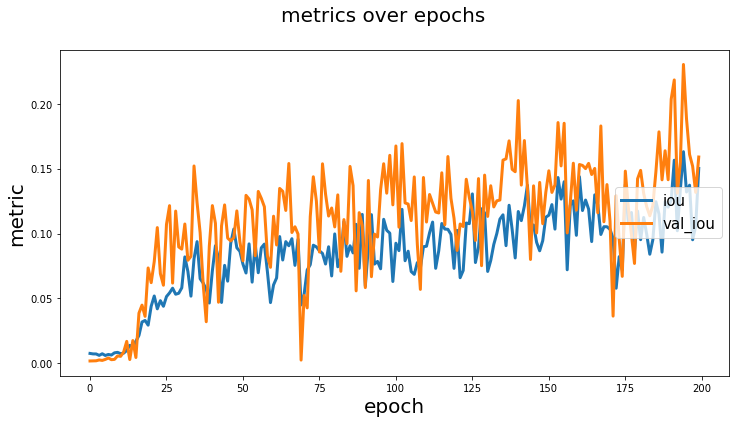

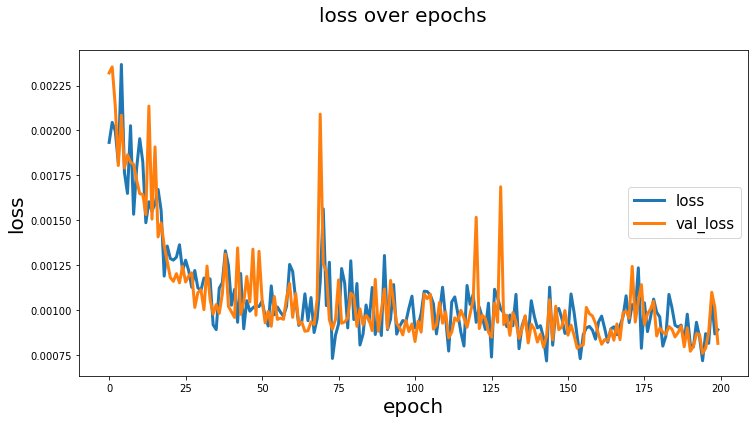

In [23]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [24]:
y_pred = model.predict(X_test)

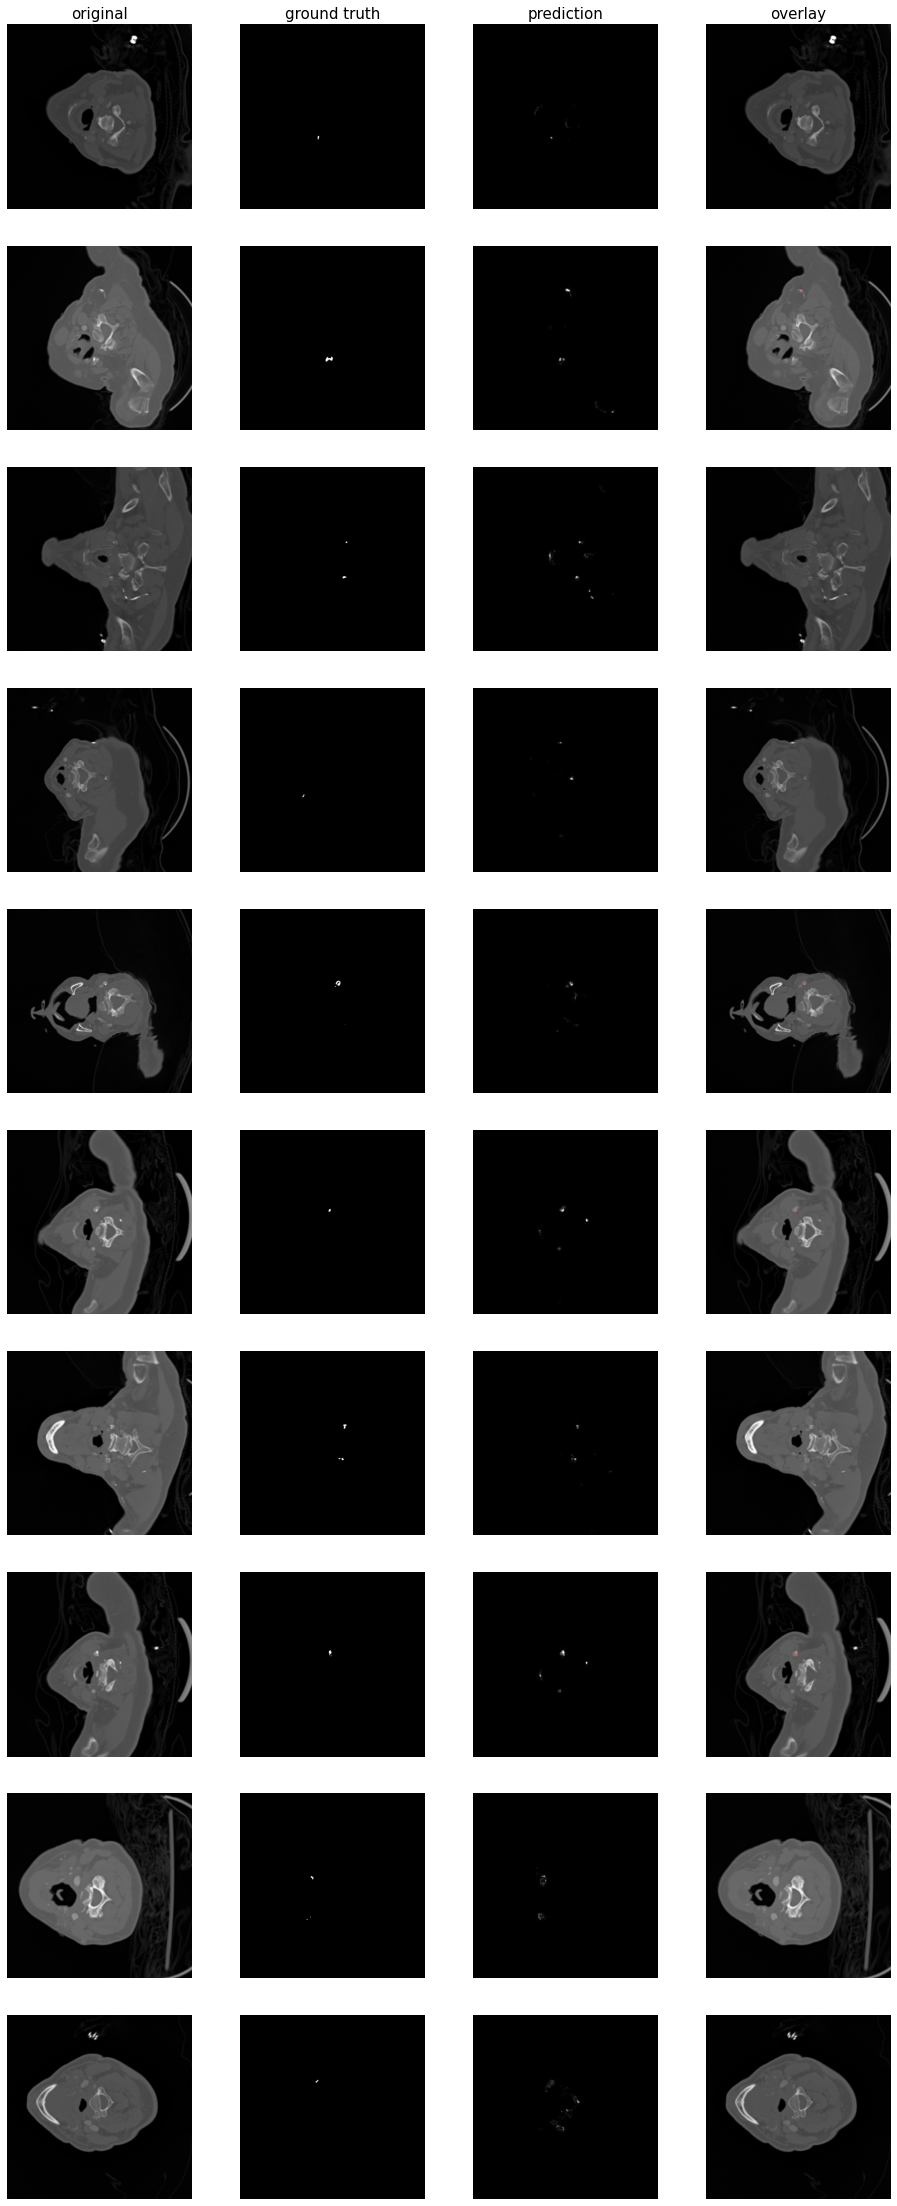

In [25]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=10)

In [26]:
loss, iou, iou_thresholded = model.evaluate(X_test, y_test)

4/4 [==============================] - 2s 356ms/step - loss: 7.6226e-04 - iou: 0.1732 - iou_thresholded: 0.2985
